### Problem Statement : Viterbi algorithm to solve the problem of unknown words using at least two techniques. 

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.
 

### Solution Approach: 
This exercise is divided into the following sections:
1. Reading and understanding the tagged dataset
2. Exploratory analysis
3. Vanilla viterbi hueristic Algorithm implementation
3. Vanilla viterbi Modification using following techniques
    - rule-based models and Lexicon Model:
    - Creating and evaluating a rule-based POS tagger
    - Creating and evaluating a lexicon POS tagger
    - Combined tagger, lexicon fallback on default tagger(rule based tagger)

In [565]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import DefaultTagger
from nltk import UnigramTagger
from nltk import BigramTagger
import math
nltk.download('universal_tagset')


[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/mamta/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 1. Data Preparation

In [566]:
# reading the Treebank tagged sentences
nltk_default_dataset = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [567]:
# first few tagged sentences
print(nltk_default_dataset[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [568]:
# Splitting the data into train and test in 95:5 ratio
random.seed(1234)
train_set, test_set = train_test_split(nltk_default_dataset,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Younkers', 'NOUN'), ('rang', 'VERB'), ('up', 'PRT'), ('sales', 'NOUN'), ('*ICH*-1', 'X'), ('in', 'ADP'), ('1988', 'NUM'), ('of', 'ADP'), ('$', '.'), ('313', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('.', '.')], [('``', '.'), ('A', 'DET'), ('lot', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('stocks', 'NOUN'), ('that', 'DET'), ('*T*-117', 'X'), ('have', 'VERB'), ('been', 'VERB'), ('under', 'ADP'), ('water', 'NOUN'), ('finally', 'ADV'), ('saw', 'VERB'), ('a', 'DET'), ('reason', 'NOUN'), ('0', 'X'), ('*', 'X'), ('to', 'PRT'), ('uptick', 'VERB'), ('*T*-1', 'X'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-2', 'X'), ('George', 'NOUN'), ('Jennison', 'NOUN'), (',', '.'), ('head', 'ADJ'), ('trader', 'NOUN'), ('of', 'ADP'), ('banking', 'NOUN'), ('issues', 'NOUN'), ('in', 'ADP'), ('Shearson', 'NOUN'), ('Lehman', 'NOUN'), ('Hutton', 'NOUN'), ("'s", 'PRT'), ('OTC', 'NOUN'), ('department', 'NOUN'), ('.', '.')], [('Program', 'NOUN'), ('trading', 'NOUN'), ('--', '.'), ('A', 'DET'), ('w

In [569]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95851

In [570]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Younkers', 'rang', 'up', 'sales', '*ICH*-1', 'in', '1988', 'of', '$', '313']

In [571]:
# vocabulary  --No. of tokens/words
V = set(tokens)
print(len(V))

12115


In [572]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [573]:
# no. of tags in the corpus..
print(T)

{'ADJ', 'ADV', 'CONJ', '.', 'PRON', 'NUM', 'VERB', 'PRT', 'NOUN', 'DET', 'ADP', 'X'}


## 2. POS Tagging Algorithm - HMM
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

To every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say Noun), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w and dividing by the count of all tags t, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and we assume that a tag will depend only on the previous tag (first-order Markov assumption). In other words, the probability of a tag being Noun will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a ADJ, then t(n) is likely to be an Noun since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices (emission and transition probabilities respectively). The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

## Emission Probabilities

In [574]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [575]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [576]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")



 large
(27, 6066)
(0, 12860)
(0, 27546) 



## Transition Probabilities

In [577]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [578]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [579]:
tags_matrix

array([[6.51170462e-02, 4.78074513e-03, 1.71447415e-02, 6.42927811e-02,
        6.59413112e-04, 2.14309264e-02, 1.21991429e-02, 1.08803166e-02,
        7.01945245e-01, 5.11045149e-03, 7.58325085e-02, 2.06066594e-02],
       [1.27545908e-01, 7.94657767e-02, 6.34390628e-03, 1.35893151e-01,
        1.53589314e-02, 3.20534222e-02, 3.46911520e-01, 1.43572623e-02,
        3.20534222e-02, 6.84474111e-02, 1.19198665e-01, 2.23706178e-02],
       [1.16612680e-01, 5.46043515e-02, 4.62748721e-04, 3.56316529e-02,
        5.87690882e-02, 4.25728820e-02, 1.60111055e-01, 4.16473858e-03,
        3.51226270e-01, 1.16612680e-01, 5.13651073e-02, 7.86672812e-03],
       [4.46156599e-02, 5.19620143e-02, 5.74269854e-02, 9.19190124e-02,
        6.49525151e-02, 8.16162005e-02, 8.87833685e-02, 2.41892133e-03,
        2.22092822e-01, 1.75685361e-01, 9.10231173e-02, 2.74144411e-02],
       [7.41885602e-02, 3.43894884e-02, 5.40958252e-03, 3.86398770e-02,
        7.34157627e-03, 6.95517752e-03, 4.88794446e-01, 1.23

In [580]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [581]:
tags_df

,ADJ,ADV,CONJ,.,PRON,NUM,VERB,PRT,NOUN,DET,ADP,X
ADJ,0.065117,0.004781,0.017145,0.064293,0.000659,0.021431,0.012199,0.010880,0.701945,0.005110,0.075833,0.020607
ADV,0.127546,0.079466,0.006344,0.135893,0.015359,0.032053,0.346912,0.014357,0.032053,0.068447,0.119199,0.022371
CONJ,0.116613,0.054604,0.000463,0.035632,0.058769,0.042573,0.160111,0.004165,0.351226,0.116613,0.051365,0.007867
.,0.044616,0.051962,0.057427,0.091919,0.064953,0.081616,0.088783,0.002419,0.222093,0.175685,0.091023,0.027414
PRON,0.074189,0.034389,0.005410,0.038640,0.007342,0.006955,0.488794,0.012365,0.209428,0.009274,0.022025,0.091190
NUM,0.033099,0.002343,0.014060,0.115700,0.001465,0.185413,0.017282,0.027534,0.355302,0.002929,0.035149,0.209725
VERB,0.064697,0.081649,0.005443,0.035614,0.034992,0.023406,0.167030,0.031960,0.111509,0.134914,0.091680,0.217107
PRT,0.083388,0.009156,0.002289,0.042838,0.017986,0.059189,0.396337,0.001962,0.250163,0.102681,0.020275,0.013734
NOUN,0.012053,0.017062,0.042801,0.240362,0.004719,0.009620,0.145720,0.043709,0.264685,0.013214,0.176831,0.029224
DET,0.205688,0.012240,0.000480,0.017761,0.003720,0.021841,0.039722,0.000240,0.637345,0.005400,0.009240,0.046322


In [582]:
tags_df.loc['.', :]

ADJ     0.044616
ADV     0.051962
CONJ    0.057427
.       0.091919
PRON    0.064953
NUM     0.081616
VERB    0.088783
PRT     0.002419
NOUN    0.222093
DET     0.175685
ADP     0.091023
X       0.027414
Name: ., dtype: float32

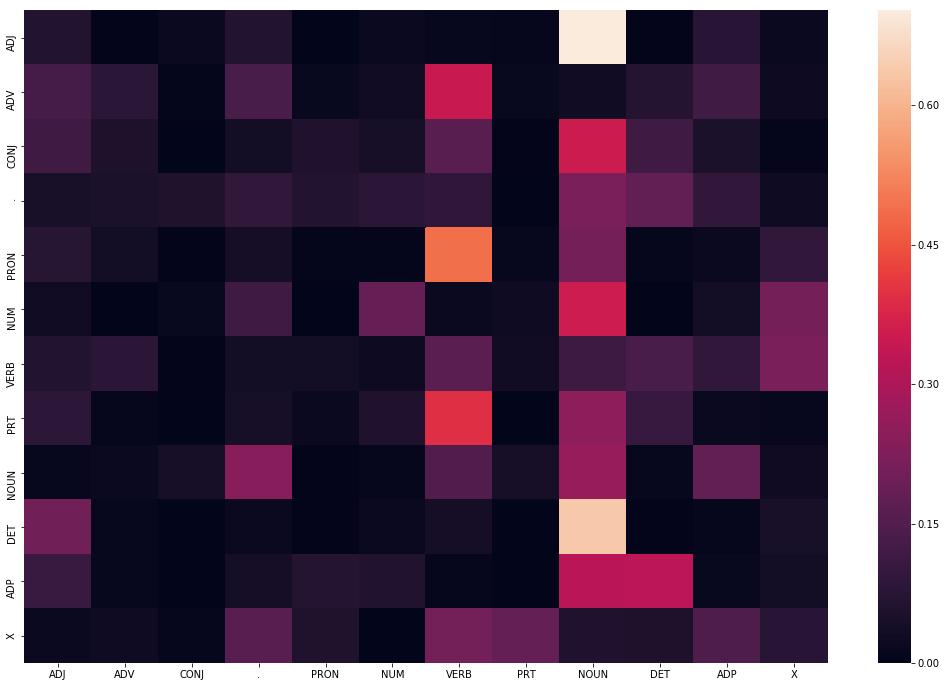

In [583]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


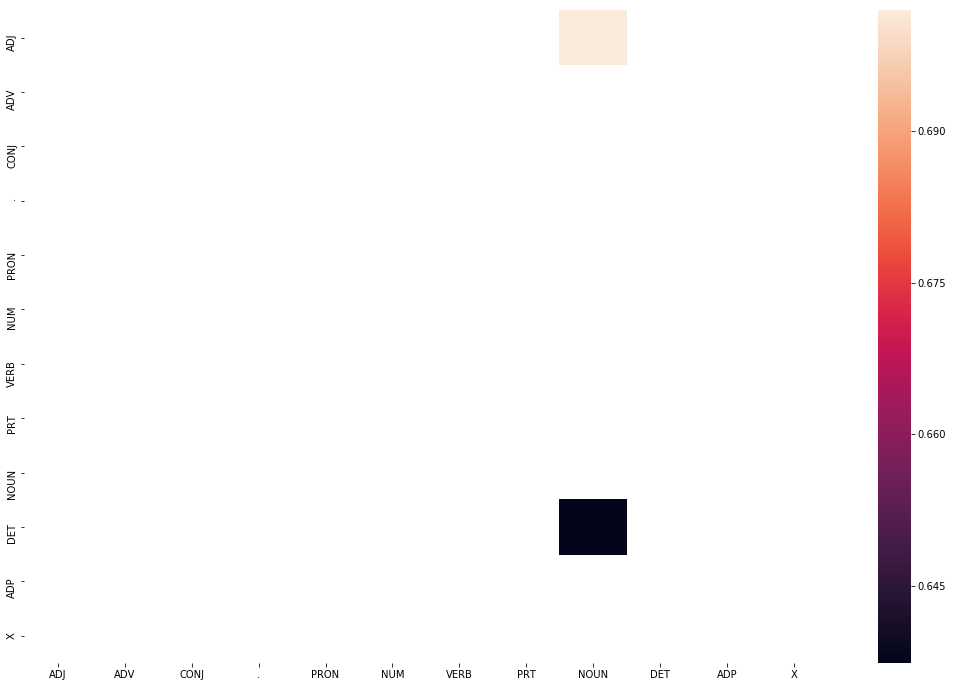

In [584]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Vanilla Viterbi algorithm  (without dealing with unknown words)

In [585]:
len(train_tagged_words)


95851

In [586]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Test Set

In [587]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

# Test the Algo on random sample test data
# choose random 5 sents
random.seed(1234)

# choose 5 random sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Mr.', 'NOUN'),
  ('Coleman', 'NOUN'),
  ('said', 'VERB'),
  ('this', 'DET'),
  ('week', 'NOUN'),
  ('that', 'ADP'),
  ('he', 'PRON'),
  ('would', 'VERB'),
  ('devote', 'VERB'),
  ('the', 'DET'),
  ('remainder', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('political', 'ADJ'),
  ('season', 'NOUN'),
  ('to', 'PRT'),
  ('positive', 'ADJ'),
  ('campaigning', 'NOUN'),
  (',', '.'),
  ('but', 'CONJ'),
  ('the', 'DET'),
  ('truce', 'NOUN'),
  ('lasted', 'VERB'),
  ('only', 'ADV'),
  ('hours', 'NOUN'),
  ('.', '.')],
 [('Drug', 'NOUN'),
  ('companies', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('key', 'ADJ'),
  ('index', 'NOUN'),
  ('also', 'ADV'),
  ('notched', 'VERB'),
  ('gains', 'NOUN'),
  ('as', 'ADP'),
  ('market-makers', 'NOUN'),
  ('searched', 'VERB'),
  ('for', 'ADP'),
  ('stock', 'NOUN'),
  ('in', 'ADP'),
  ('anticipation', 'NOUN'),
  ('of', 'ADP'),
  ('demand', 'NOUN'),
  ('due', 'ADJ'),
  ('to', 'PRT'),
  ('the', 'DET'),
  ('sector', 'NOUN'),
  ("'s", 'PRT'),
  ('defensiv

In [588]:
# tagging the test sentences
start = time.time()
tagged_seq_Vanila = Viterbi(test_tagged_words)  # apply viterbi on sample test set
end = time.time()
difference = end-start

In [589]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  78.07979989051819
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', '

In [590]:
# accuracy
check = [i for i, j in zip(tagged_seq_Vanila, test_run_base) if i == j] 
vanila_viterbi_accuracy = len(check)/len(tagged_seq_Vanila)
vanila_viterbi_accuracy

0.9127725856697819

In [591]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_Vanila, test_run_base)) if j[0]!=j[1]]

In [592]:
# check the words tagged incorrectly
incorrect_tagged_cases

[[('truce', 'NOUN'), (('lasted', 'ADJ'), ('lasted', 'VERB'))],
 [('lasted', 'VERB'), (('only', 'ADJ'), ('only', 'ADV'))],
 [('also', 'ADV'), (('notched', 'ADJ'), ('notched', 'VERB'))],
 [('market-makers', 'NOUN'), (('searched', 'ADJ'), ('searched', 'VERB'))],
 [('defensive', 'ADJ'), (('qualities', 'ADJ'), ('qualities', 'NOUN'))],
 [('and', 'CONJ'), (('museums', 'ADJ'), ('museums', 'NOUN'))],
 [('Robert', 'NOUN'), (('Persky', 'ADJ'), ('Persky', 'NOUN'))],
 [('the', 'DET'), (('Photograph', 'ADJ'), ('Photograph', 'NOUN'))],
 [('Photograph', 'NOUN'), (('Collector', 'ADJ'), ('Collector', 'NOUN'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('a', 'DET'), (('boost', 'VERB'), ('boost', 'NOUN'))],
 [('like', 'ADP'), (('Grgich', 'ADJ'), ('Grgich', 'NOUN'))],
 [('Hills', 'NOUN'), (('Chardonnay', 'ADJ'), ('Chardonnay', 'NOUN'))],
 [('slow', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('high-priced', 'ADJ'), (('red', 'NOUN'), ('red', 'ADJ'))],
 [('and', 'CONJ'), (('Chardonnays', 

In [593]:
# lets test the given data set. 
sentence_test = open('Test_sentences.txt',mode='r').read()

# First convert the sentence into tokenized words
words = word_tokenize(sentence_test)

# Apply the viterbi algo.
start = time.time()
tagged_seq_Vanila = Viterbi(words)
end = time.time()
difference = end-start

# print the tagged words
print(tagged_seq_Vanila)
print(difference)
vannila_test_tagged_seq = tagged_seq_Vanila

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Observation :
-  We can observe that unknown words are tagged wrongly as below
- ('Android', 'ADJ')
- ('Google', 'ADJ')
- ('2015', 'ADJ')
- ('Twitter', 'ADJ')
- ('2018', 'ADJ')
- ('FIFA', 'ADJ')
- ('ICESAT-2', 'ADJ')
- ('domineering', 'ADJ')

## 3. Solve the problem of unknown words

### Approach 1 : Rule Based Tagging with Viterbi

In [594]:
# Write a new function to define the pattern for modification

pattern = [
        (r'.*Twitter$', 'NOUN'), # Special words should be tagged as high frequency tag, which is Noun 
        (r'.*Android$', 'NOUN'),  # Special words should be tagged as high frequency tag, which is Noun
        (r'.*Google$', 'NOUN'),   # Special words should be tagged as high frequency tag, which is Noun
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*es$', 'VERB'), 
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [595]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)  # call the rule based tagging function to apply modification
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


# Test the modified Algo on random sample test data
# choose random 5 sents
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
# test the data using the modified viterbi Algorithm
start = time.time()
tagged_seq_rule_based_tagger = modified_Viterbi_rule_based(test_tagged_words) 
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_rule_based_tagger)

lasted
VERB
notched
VERB
searched
VERB
qualities
VERB
museums
NOUN
Persky
NOUN
Photograph
NOUN
Collector
NOUN
Grgich
NOUN
Chardonnay
NOUN
Chardonnays
NOUN
screened
VERB
card-member
NOUN
incomes
VERB
missed
VERB
natural-gas
NOUN
forecasting
VERB
corkscrews
NOUN
Time taken in seconds:  77.29757595062256
[('Mr.', 'NOUN'), ('Coleman', 'NOUN'), ('said', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), ('that', 'ADP'), ('he', 'PRON'), ('would', 'VERB'), ('devote', 'VERB'), ('the', 'DET'), ('remainder', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('political', 'ADJ'), ('season', 'NOUN'), ('to', 'PRT'), ('positive', 'ADJ'), ('campaigning', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('the', 'DET'), ('truce', 'NOUN'), ('lasted', 'VERB'), ('only', 'ADV'), ('hours', 'NOUN'), ('.', '.'), ('Drug', 'NOUN'), ('companies', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('key', 'ADJ'), ('index', 'NOUN'), ('also', 'ADV'), ('notched', 'VERB'), ('gains', 'NOUN'), ('as', 'ADP'), ('market-makers', 'NOUN'), ('searched', 'VERB'), 

In [596]:
# accuracy
check = [i for i, j in zip(tagged_seq_rule_based_tagger, test_run_base) if i == j] 
rulebased_viterbi_accuracy = len(check)/len(tagged_seq_rule_based_tagger)
print(rulebased_viterbi_accuracy)

0.9657320872274143


In [597]:
# check the words tagged incorrectly
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_rule_based_tagger, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('defensive', 'ADJ'), (('qualities', 'VERB'), ('qualities', 'NOUN'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('a', 'DET'), (('boost', 'VERB'), ('boost', 'NOUN'))],
 [('slow', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('high-priced', 'ADJ'), (('red', 'NOUN'), ('red', 'ADJ'))],
 [('*U*', 'X'), (('range', 'VERB'), ('range', 'NOUN'))],
 [('holders', 'NOUN'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('household', 'NOUN'), (('incomes', 'VERB'), ('incomes', 'NOUN'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('third-quarter', 'NOUN'), (('net', 'NOUN'), ('net', 'ADJ'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))]]

### Observation: rule_based_tagger
### we can see that below words has been tagged correctly which were wrongly tagged by vanila Algorithm on the test set.
1. choice  - NOUN
2. 126.1 - NUM
3. discretion - NOUN
4. select - NOUN


In [598]:
# Test the Algo on given data set
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq_rule_based_tagger = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq_rule_based_tagger)
print(difference)
rulebased_test_tagged_seq = tagged_seq_rule_based_tagger

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

### Approach 2 : lexicon Based Tagging ( Bigram tagger ) with Viterbi

In [599]:
# write a new function to define modification

def bigram_tagger(wording) :
    t0 = nltk.DefaultTagger('NOUN')  # set the default tag as NOUN(most frequently used tag)
    t1 = nltk.UnigramTagger(train_set, backoff=t0)  # unigram fallback on default tagger(NOUN)
    t2 = nltk.BigramTagger(train_set, backoff=t1)  # bigram fallback on unigram
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [600]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = bigram_tagger(word)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# Test the modified Algo on random sample test data
# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
#test the few sample sentence from the test set using modified viterbi algorithm
start = time.time()
tagged_seq_lexicon_tagger = modified_Viterbi_lexicon_based(test_tagged_words)  
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_lexicon_tagger)

Time taken in seconds:  93.85923528671265
[('Mr.', 'NOUN'), ('Coleman', 'NOUN'), ('said', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), ('that', 'ADP'), ('he', 'PRON'), ('would', 'VERB'), ('devote', 'VERB'), ('the', 'DET'), ('remainder', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('political', 'ADJ'), ('season', 'NOUN'), ('to', 'PRT'), ('positive', 'ADJ'), ('campaigning', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('the', 'DET'), ('truce', 'NOUN'), ('lasted', 'NOUN'), ('only', 'ADV'), ('hours', 'NOUN'), ('.', '.'), ('Drug', 'NOUN'), ('companies', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('key', 'ADJ'), ('index', 'NOUN'), ('also', 'ADV'), ('notched', 'NOUN'), ('gains', 'NOUN'), ('as', 'ADP'), ('market-makers', 'NOUN'), ('searched', 'NOUN'), ('for', 'ADP'), ('stock', 'NOUN'), ('in', 'ADP'), ('anticipation', 'NOUN'), ('of', 'ADP'), ('demand', 'NOUN'), ('due', 'ADJ'), ('to', 'PRT'), ('the', 'DET'), ('sector', 'NOUN'), ("'s", 'PRT'), ('defensive', 'ADJ'), ('qualities', 'NOUN'), ('.', '.'), ('Corporati

In [601]:
# accuracy
check = [i for i, j in zip(tagged_seq_lexicon_tagger, test_run_base) if i == j] 
lexicon_viterbi_accuracy = len(check)/len(tagged_seq_lexicon_tagger) 
print(lexicon_viterbi_accuracy)  # accuracy has increaed

# check the words tagged incorrectly
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_lexicon_tagger, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9532710280373832


[[('truce', 'NOUN'), (('lasted', 'NOUN'), ('lasted', 'VERB'))],
 [('also', 'ADV'), (('notched', 'NOUN'), ('notched', 'VERB'))],
 [('market-makers', 'NOUN'), (('searched', 'NOUN'), ('searched', 'VERB'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('a', 'DET'), (('boost', 'VERB'), ('boost', 'NOUN'))],
 [('slow', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('high-priced', 'ADJ'), (('red', 'NOUN'), ('red', 'ADJ'))],
 [('*U*', 'X'), (('range', 'VERB'), ('range', 'NOUN'))],
 [('GMAC', 'NOUN'), (('screened', 'NOUN'), ('screened', 'VERB'))],
 [('holders', 'NOUN'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('``', '.'), (('missed', 'NOUN'), ('missed', 'VERB'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('third-quarter', 'NOUN'), (('net', 'NOUN'), ('net', 'ADJ'))],
 [('is', 'VERB'), (('forecasting', 'NOUN'), ('forecasting', 'VERB'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))]]

### Observation: lexicon_tagger
#### we can see that below words has been correctly tagged after modification.
1. choice - NOUN
2. discretion -  Noun
3. whereas '126.1' this was correctly tagged as NUM by rule based but not correctly tagged by Lexican based

In [602]:
# Test the Algo on given data set
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

### Approach 3 : Combining Taggers with Viterbi

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger. 

Also, note that the rule-based tagger itself is backed up by the tag 'NOUN'.


In [603]:
# write a new function to define modification
patterns = [
        (r'.*Twitter$', 'NOUN'), # Special words should be tagged as high frequency tag, which is Noun 
        (r'.*Android$', 'NOUN'),  # Special words should be tagged as high frequency tag, which is Noun
        (r'.*Google$', 'NOUN'),   # Special words should be tagged as high frequency tag, which is Noun
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*es$', 'VERB'), 
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def combined_tagger(wording) :
      # set the default tagger as rule_based_tagging
    rule_based_tagger = nltk.RegexpTagger(patterns)
    t1 = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
    t2 = nltk.BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [604]:
# Viterbi Heuristic
def modified_Viterbi_combined(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = combined_tagger(word)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# Test the modified Algo on random sample test data
# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
#test the few sample sentence from the test set using modified viterbi algorithm
start = time.time()
tagged_seq_combined_tagger = modified_Viterbi_combined(test_tagged_words)  
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_combined_tagger)

Time taken in seconds:  127.35134100914001
[('Mr.', 'NOUN'), ('Coleman', 'NOUN'), ('said', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), ('that', 'ADP'), ('he', 'PRON'), ('would', 'VERB'), ('devote', 'VERB'), ('the', 'DET'), ('remainder', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('political', 'ADJ'), ('season', 'NOUN'), ('to', 'PRT'), ('positive', 'ADJ'), ('campaigning', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('the', 'DET'), ('truce', 'NOUN'), ('lasted', 'VERB'), ('only', 'ADV'), ('hours', 'NOUN'), ('.', '.'), ('Drug', 'NOUN'), ('companies', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('key', 'ADJ'), ('index', 'NOUN'), ('also', 'ADV'), ('notched', 'VERB'), ('gains', 'NOUN'), ('as', 'ADP'), ('market-makers', 'NOUN'), ('searched', 'VERB'), ('for', 'ADP'), ('stock', 'NOUN'), ('in', 'ADP'), ('anticipation', 'NOUN'), ('of', 'ADP'), ('demand', 'NOUN'), ('due', 'ADJ'), ('to', 'PRT'), ('the', 'DET'), ('sector', 'NOUN'), ("'s", 'PRT'), ('defensive', 'ADJ'), ('qualities', 'VERB'), ('.', '.'), ('Corporat

In [605]:
# accuracy
check = [i for i, j in zip(tagged_seq_combined_tagger, test_run_base) if i == j] 
Combined_viterbi_accuracy = len(check)/len(tagged_seq_combined_tagger) 
print(Combined_viterbi_accuracy)  # accuracy has increaed

# check the words tagged incorrectly
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_combined_tagger, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9657320872274143


[[('defensive', 'ADJ'), (('qualities', 'VERB'), ('qualities', 'NOUN'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('a', 'DET'), (('boost', 'VERB'), ('boost', 'NOUN'))],
 [('slow', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('high-priced', 'ADJ'), (('red', 'NOUN'), ('red', 'ADJ'))],
 [('*U*', 'X'), (('range', 'VERB'), ('range', 'NOUN'))],
 [('holders', 'NOUN'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('household', 'NOUN'), (('incomes', 'VERB'), ('incomes', 'NOUN'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('third-quarter', 'NOUN'), (('net', 'NOUN'), ('net', 'ADJ'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))]]

### Observation: Combined tagger
- Below words has been tagged correctly as compared to vanila method
1. '126.1', 'NUM'
2. 'choice', 'NOUN'
3. '$', '.'

In [606]:
# Test the Algo on given data set
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_combined(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
Combined_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

## 4. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [607]:
print("Vannila Viterbi Accuracy: "+ str(vanila_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_viterbi_accuracy))
print("Combined Viterbi Accuracy: "+ str(Combined_viterbi_accuracy))

# From the results we can observe that Accuracy has increased from 91% to 95% AND 96% 
# by using the modification of rule based and lexical Models.

Vannila Viterbi Accuracy: 0.9127725856697819
Rule Based Viterbi Accuracy: 0.9657320872274143
Lexicon Based Viterbi Accuracy: 0.9532710280373832
Combined Viterbi Accuracy: 0.9657320872274143


## 5. List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications


1.  Words like 'Google','Twitter','Android'  are properly tagged with 'NOUN' in modified Viterbi Algorithm
2.  Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (a word in all captial letters generally will be an abbrevation and it is a noun). 
3.  Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' in Rule Based Tagging
4. Words with integers or float are properly tagged as 'NUM' in rule based tagger.
5. In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers is not able to tag them. And it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.
6. In the combined tagger, laxican tagger fall back on rule based tagger so as to make a strong tagger.